In [ ]:
!pip install -r requirements.txt --quiet

In [1]:
import json
import time
from bedrock_text import BedrockText
from bedrock_image import BedrockAmazonImage, NovaImageSize, ImageParams
from bedrock_video import BedrockAmazonVideo, VideoStatus
from bedrock_model import BedrockModel
from image_utils import (
    get_image_bytes_from_file,
    bytes_to_image,
    encode_image_base64,
    display_image,
    display_image_bytes,
    display_video_bytes,
    create_outpainting_mask
)

## 0. Declare required models, classes, variables, and data

In [2]:
AWS_REGION = "us-east-1"
S3_VIDEO_BUCKET = "hi-nova-video"

SAMPLE_IMAGE_PATH = "./img/ref1-sole hamburger.png"
SAMPLE_IMAGE_FORMAT = "png"

In [3]:
# LLM model
bedrock_llm = BedrockText(modelId=BedrockModel.NOVA_LITE_CR, region=AWS_REGION)

# Image model
bedrock_image = BedrockAmazonImage(region=AWS_REGION, modelId=BedrockModel.NOVA_CANVAS)

# Video model
bedrock_video = BedrockAmazonVideo(
    region=AWS_REGION,
    modelId=BedrockModel.NOVA_REEL,
    bucket_name=S3_VIDEO_BUCKET
)

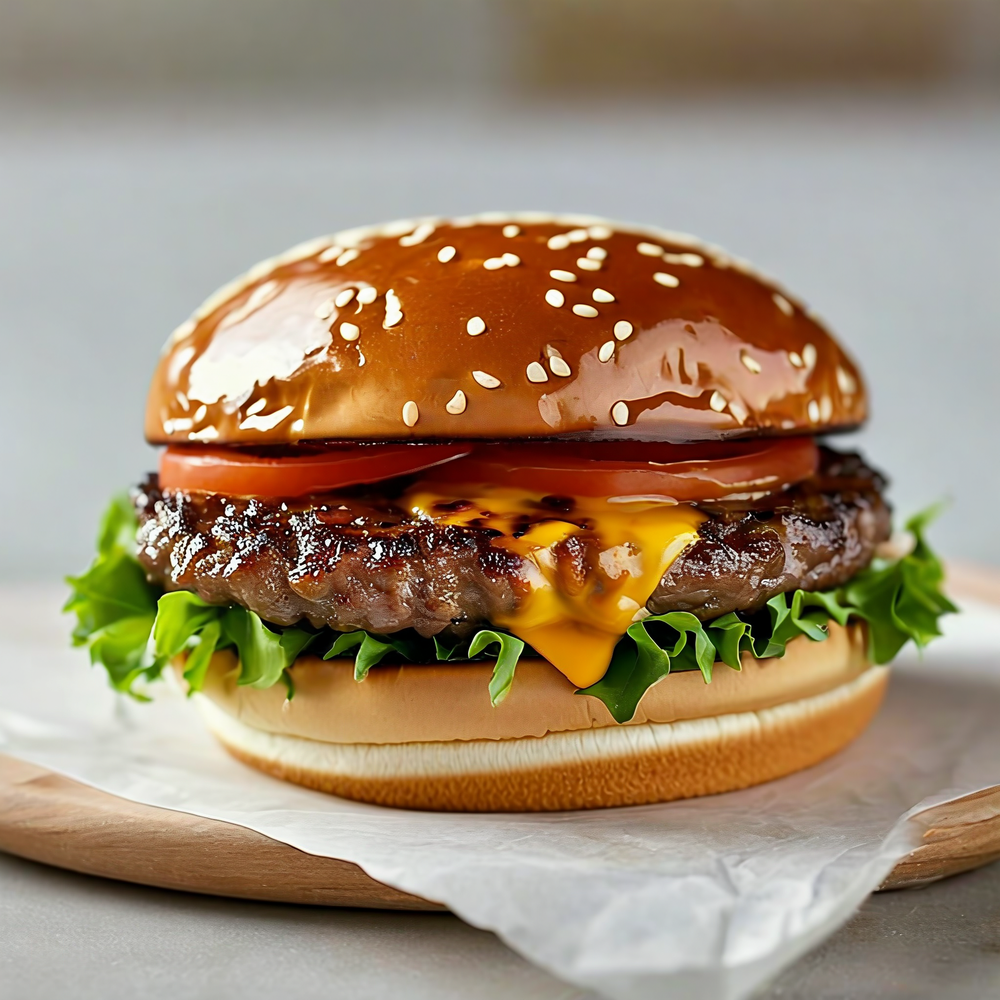

In [14]:
# sample image
img_bytes = get_image_bytes_from_file(file_path=SAMPLE_IMAGE_PATH, format=SAMPLE_IMAGE_FORMAT)
display_image_bytes(img_bytes)

# (Optional) if you have any information about the image, fill in this field.
photo_text = ""

## 1. Creating image prompts for outpainting (Nova Lite)

In [15]:
PROMPT = f"""You are a copywriter who looks at an image and creates ideas to expand that image.
Refer to the given image and image description to write an expanded image description in one sentence in English.

## Image Description

{photo_text}

## Output Format

Please provide your description in the following format, without any additional explanation:
{{
    "image_prompt": "A one-sentence visual description of the food items included in the image"
}}
"""

res = bedrock_llm.converse_output(text=PROMPT, image=img_bytes, format=SAMPLE_IMAGE_FORMAT)
outpainting_prompt = json.loads(res).get('image_prompt', '')
print(outpainting_prompt)

A close-up of a hamburger with a sesame seed bun, melted cheese, and a slice of tomato on a wooden plate.


## 2. Expand an image (Nova Canvas)

In [16]:
img = bytes_to_image(img_bytes)

width, height = NovaImageSize.SIZE_1280x720.value
image_params = ImageParams(
    count=1,
    width=width,
    height=height,
    cfg=8.0,
    seed=124,
)


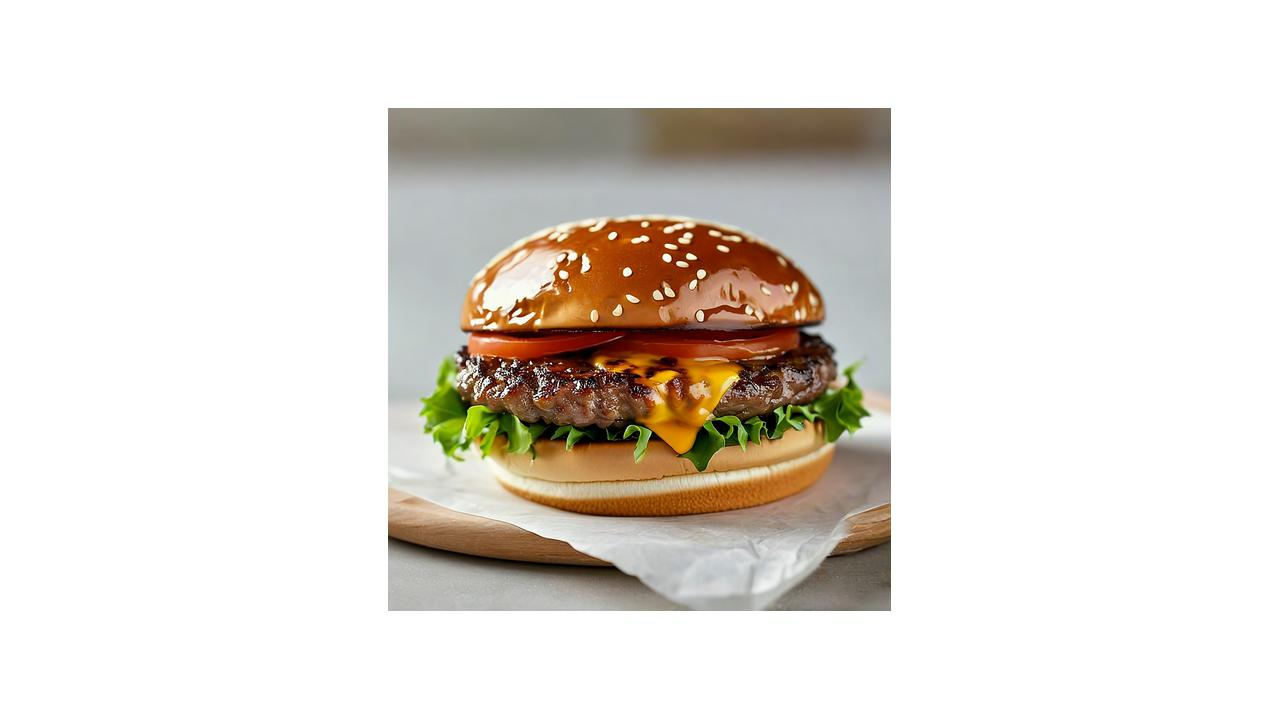


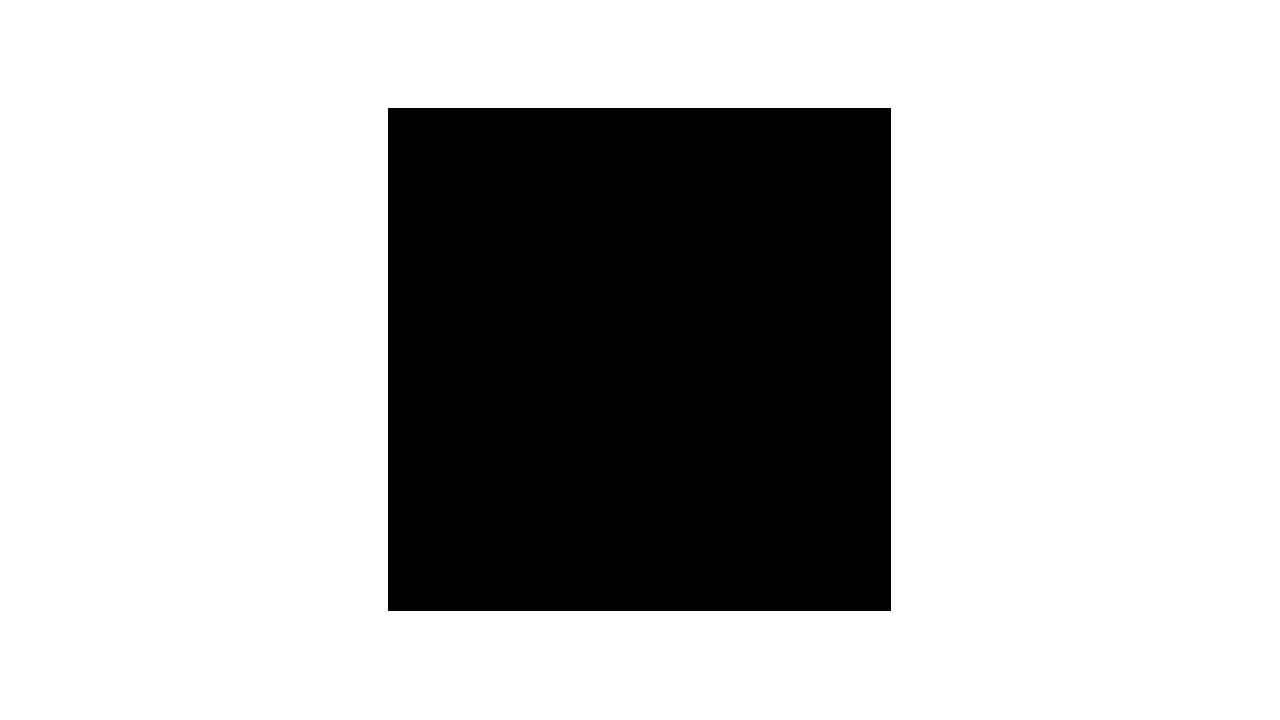

In [17]:
extended_image, mask_image = create_outpainting_mask(
    img,
    width,
    height,
    position=(0.5, 0.5),
    size_ratio=0.7,
)

extended_image_base64 = encode_image_base64(extended_image)
mask_image_base64 = encode_image_base64(mask_image)

display_image(extended_image_base64)
display_image(mask_image_base64)


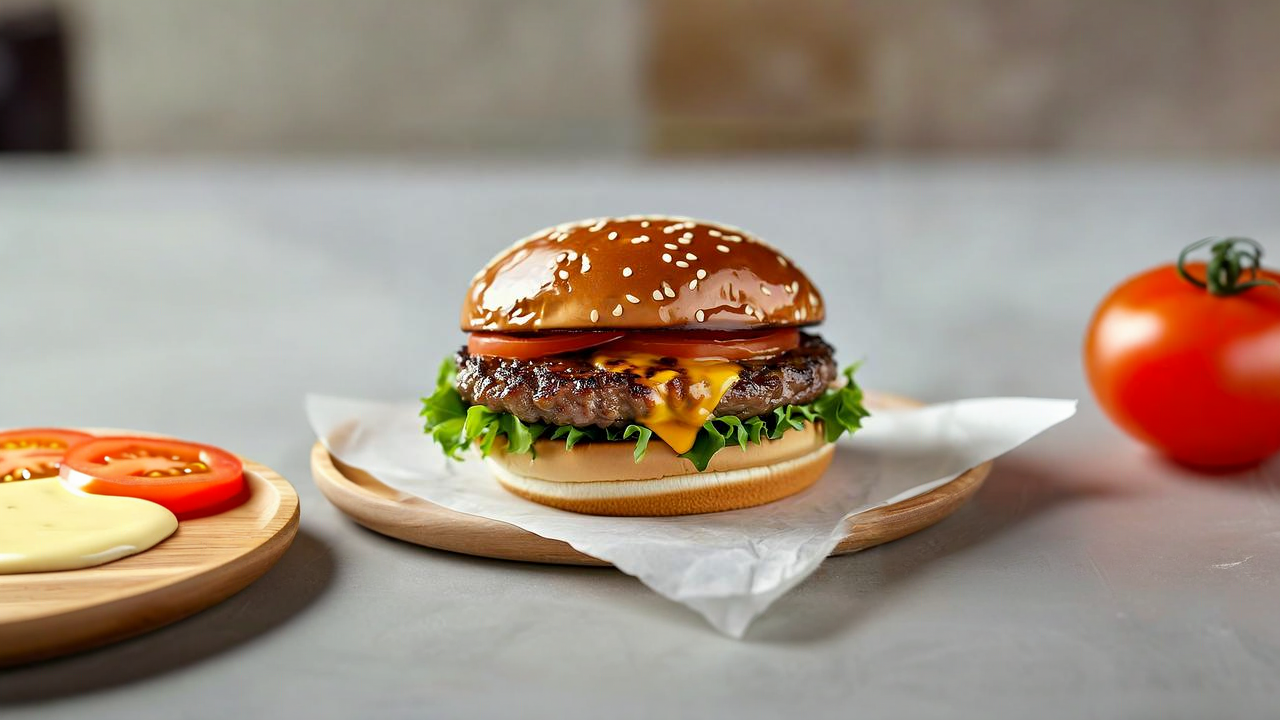

In [18]:
body = image_params.outpainting(image=extended_image_base64,
                                mask_image=mask_image_base64,
                                text=outpainting_prompt)
img = bedrock_image.generate_image(body)
display_image(img)

## 3. Generate a Video Prompt (Nova Lite)

In [9]:
PROMPT = f"""You are a prompt engineer specializing in crafting prompts for image-to-video generation.
Refer to the given image and image description to write a dynamic, high-quality video generation prompt in English

## Image Description
{photo_text}

## Instruction
Video generation models work best with descriptive prompts rather than command-based instructions. When crafting prompts, focus on what you want to see rather than telling the model what to do. Think of writing a detailed caption or scene description like you’re explaining a video that already exists. For example, describing elements like the main subjects, what they’re doing, the setting around them, how the scene is lit, the overall artistic style, and any camera movements can help create more accurate results. The key is to paint a complete picture through description rather than giving step-by-step directions. This means instead of saying “create a dramatic scene,” you could describe “a stormy beach at sunset with crashing waves and dark clouds, filmed with a slow aerial shot moving over the coastline.” The more specific and descriptive you can be about the visual elements you want, the better the output will be. You might want to include details about the subject, action, environment, lighting, style, and camera motion.

When writing a video generation prompt for Nova Reel, be mindful of the following requirements and best practices:

Prompts must be no longer than 512 characters.
For best results, place camera movement descriptions at the start or end of your prompt.
Specify what you want to include rather than what to exclude. For example, instead of “fruit basket with no bananas,” say “fruit basket with apples, oranges, and pears.”
When describing camera movements in your video prompts, be specific about the type of motion you want—whether it’s a smooth dolly shot (moving forward/backward), a pan (sweeping left/right), or a tilt (moving up/down). For more dynamic effects, you can request aerial shots, orbit movements, or specialized techniques like dolly zooms. You can also specify the speed of the movement

## Example
- Track right shot of single red balloon floating through empty subway tunnel. Balloon glows from within, casting soft red light on concrete walls. Cinematic 4k, moody lighting
- Dolly in shot of peaceful deer drinking from forest stream. Sunlight filtering through and bokeh of other deer and forest plants. 4k cinematic.
- Orbit shot of crystal light bulb centered on polished marble surface, gentle floating gears spinning inside with golden glow. Premium lighting. 4k cinematic.
- Pedestal down in a pan in modern kitchen penne pasta with heavy cream white sauce on top, mushrooms and garlic, steam coming out.
- Orbit shot of premium over-ear headphones on a reflective surface. Dramatic side lighting accentuates the curves and edges, casting subtle shadows that highlight the product’s premium build quality.

## Output format

Please provide your description in the following format, without any additional explanation:
{{
    "video_prompt": "Video generation prompt in English"
}}
"""

res = bedrock_llm.converse_output(text=PROMPT)
video_prompt = json.loads(res).get('video_prompt', '')
print(video_prompt)

Aerial shot of a serene forest clearing at dawn, with a gentle mist rising from the ground. Sunlight filters through the trees, casting a warm, golden glow on the dew-covered leaves. A family of deer emerges from the trees, grazing peacefully. The camera slowly orbits around the clearing, capturing the tranquil beauty of the scene. Cinematic 4k, soft and natural lighting.


## 4. Generate an image-to-video (Nova Reel)

In [10]:
invocation_arn = bedrock_video.generate_video(
    text=video_prompt,
    image=img[0],
    imageFormat="png",
    durationSeconds=6,
    fps=24,
    dimension="1280x720"
)

status, s3Uri, invocation = bedrock_video.query_job(invocation_arn)

while status == VideoStatus.IN_PROGRESS:
    time.sleep(30)
    status, s3Uri, invocation = bedrock_video.query_job(invocation_arn)

video = bedrock_video.get_video(invocation_arn=invocation_arn)
display_video_bytes(video)